## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from geopy.geocoders import Nominatim
import plotly.express as px
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time 
from bs4 import BeautifulSoup

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.glassdoor.com/Job/software-engineer-jobs-SRCH_KO0,17.htm")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.glassdoor.com/Job/software-engineer-jobs-SRCH_KO0,17.htm")

job_data = []


# # Define a function to scrape jobs from the current page
# def scrape_page():
#     # Get the page source and parse it
#     soup = BeautifulSoup(driver.page_source, 'html.parser')
    
#     # Find all job cards on the page
#     job_cards = soup.find_all('li', class_=lambda x: x and 'JobsList_jobListItem' in x)
    
#     for job in job_cards:
#         try:
#             title_tag = job.select_one('a[data-test="job-title"]')
#             title = title_tag.get_text(strip=True) if title_tag else "N/A"
#         except Exception as e:
#             title = "N/A"
#             print(f"Error extracting title: {e}")
        
#         try:
#             company_raw = job.find('div', class_='EmployerProfile_profileContainer__63w3R').text.strip()
#             company = re.sub(r'\d\.\d$', '', company_raw)  # Remove trailing rating like "4.8"
#         except Exception as e:
#             company = "N/A"
#             print(f"Error extracting company: {e}")
        
#         try:
#             location = job.find('div', {'data-test': 'emp-location'}).text.strip()
#         except Exception as e:
#             location = "N/A"
#             print(f"Error extracting location: {e}")
        
#         try:
#             salary = job.find('div', {'data-test': 'detailSalary'}).text.strip()
#         except Exception as e:
#             salary = "N/A"
#             print(f"Error extracting salary: {e}")

#         job_data.append([title, company, location, salary])

# # Function to click "Show more jobs" until all jobs are loaded
# def load_all_jobs(max_clicks=15):
#     click_count = 0
#     while click_count < max_clicks:
#         try:
#             # Wait for the "Show more jobs" button to be clickable
#             next_button = WebDriverWait(driver, 10).until(
#                  EC.element_to_be_clickable((By.XPATH, "//button[.//span[contains(text(), 'Show more jobs')]]"))
#             )
            
#             # If the button is found, click it
#             next_button.click()
#             click_count += 1  # Increment the click counter
#             print(f"Clicked 'Show more jobs' {click_count} times.")
            
#             time.sleep(5)  # Wait for new jobs to load
            
#             # Scrape the newly loaded jobs
#             scrape_page()
            
#         except Exception as e:
#             print(f"Error clicking the 'Show more jobs' button: {e}")
#             break  # Break the loop if there's an issue (e.g., button not found)


# # Wait for page to load
# time.sleep(5)

# # Start loading and scraping all jobs
# scrape_page()  # Scrape the initial set of jobs
# load_all_jobs(max_clicks=15)  # Load more jobs by clicking the "Show more jobs" button up to 15 times

# # Create the DataFrame with the data
# df = pd.DataFrame(job_data, columns=['Job Title', 'Company', 'Location', 'Salary'])

# # Print the DataFrame
# print(df)

df = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\glassdoor_jobs.csv")

### Data Cleaning

In [ ]:
duplicates = df[df.duplicated(['Company', 'Job Title'], keep=False)]

# Sort by company and title for better visualization
duplicates_sorted = duplicates.sort_values(['Company', 'Job Title'])

# Display results
print(f"Found {len(duplicates)} duplicate job titles within companies")
print(duplicates_sorted)

# Get summary counts
dupe_summary = duplicates.groupby(['Company', 'Job Title']).size().reset_index(name='count')
print("\nDuplicate summary:")
print(dupe_summary[dupe_summary['count'] > 1])

### Salary Cleaning

In [3]:
def extract_salary(salary_str):
    if pd.isna(salary_str):
        return np.nan, np.nan
    
    # Handle hourly rates
    if 'Per Hour' in salary_str:
        numbers = re.findall(r'\d+\.?\d*', salary_str)
        if len(numbers) >= 2:
            low = float(numbers[0]) * 2080  # Convert hourly to annual (2080 work hours/year)
            high = float(numbers[1]) * 2080
            return low, high
        elif len(numbers) == 1:
            val = float(numbers[0]) * 2080
            return val, val
    
    # Handle salary ranges
    numbers = re.findall(r'\d+\.?\d*', salary_str.replace(',', ''))
    if 'K' in salary_str:
        if len(numbers) >= 2:
            return float(numbers[0]) * 1000, float(numbers[1]) * 1000
        elif len(numbers) == 1:
            val = float(numbers[0]) * 1000
            return val, val
    else:
        if len(numbers) >= 2:
            return float(numbers[0]), float(numbers[1])
        elif len(numbers) == 1:
            val = float(numbers[0])
            return val, val
    
    return np.nan, np.nan

df[['salary_low', 'salary_high']] = df['Salary'].apply(
    lambda x: pd.Series(extract_salary(x)))
df['salary_avg'] = (df['salary_low'] + df['salary_high']) / 2


### Processing Job Title Into Experience

In [4]:
def get_experience_level(title):
    title = str(title).lower()
    if 'junior' in title or 'entry' in title or 'i ' in title or 'associate' in title:
        return 'Entry'
    elif 'senior' in title or 'sr.' in title or 'iii' in title or '3' in title:
        return 'Senior'
    elif 'ii' in title or '2' in title or 'mid' in title:
        return 'Mid'
    elif 'i' in title or '1' in title:
        return 'Entry'
    else:
        return 'Not Specified'

df['experience_level'] = df['Job Title'].apply(get_experience_level)

### Categorizing Jobs

In [11]:

def extract_tech(title):
    title = str(title).lower()
    techs = []
    if 'java' in title:
        techs.append('Java')
    if 'python' in title:
        techs.append('Python')
    if 'c++' in title:
        techs.append('C++')
    if 'backend' in title:
        techs.append('Backend')
    if 'frontend' in title or 'front end' in title:
        techs.append('Frontend')
    if 'full stack' in title:
        techs.append('Full Stack')
    if 'data' in title:
        techs.append('Data')
    if 'cloud' in title:
        techs.append('Cloud')
    return ', '.join(techs) if techs else 'Other'


df['tech_keywords'] = df['Job Title'].apply(extract_tech)
tech_salaries = df.groupby('tech_keywords')['salary_avg'].mean().sort_values(ascending=False)

### Locations

In [5]:
df['is_remote'] = df['Location'].str.contains('remote', case=False)

# Clean location data
def clean_location(loc):
    if pd.isna(loc) or 'remote' in str(loc).lower() or 'united states' in str(loc).lower():
        return 'Remote'
    loc = str(loc).split(',')[0].strip()
    return loc

df['clean_location'] = df['Location'].apply(clean_location)

## Visualiztions 

### Salary Distribution

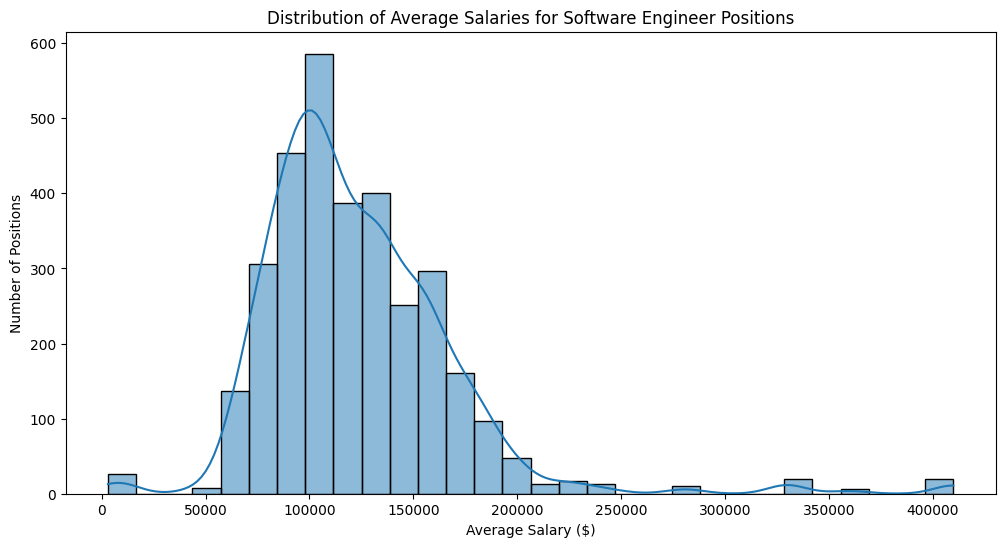

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_avg'].dropna(), bins=30, kde=True)
plt.title('Distribution of Average Salaries for Software Engineer Positions')
plt.xlabel('Average Salary ($)')
plt.ylabel('Number of Positions')
plt.show()


### Salary By Experince Level

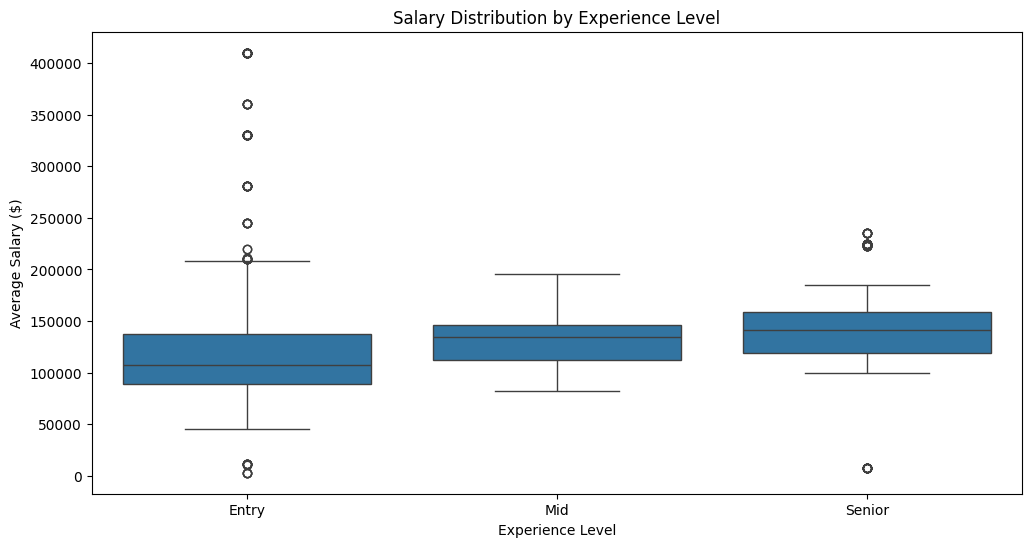

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='experience_level', y='salary_avg', data=df[df['experience_level'] != 'Not Specified'],
            order=['Entry', 'Mid', 'Senior'])
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary ($)')
plt.show()

### Top Hiring Companies

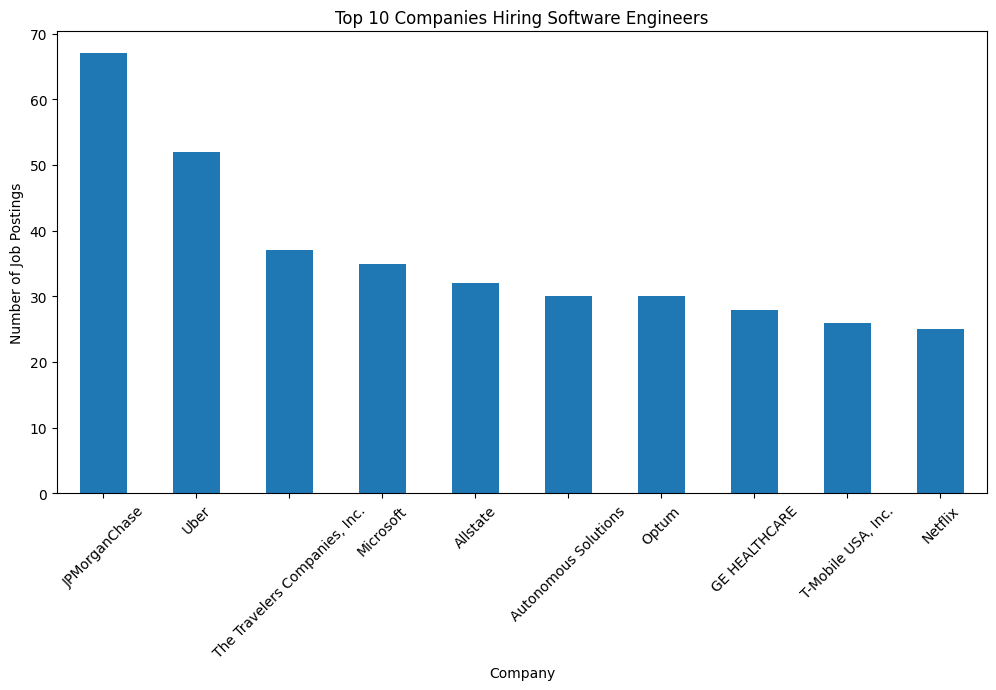

In [8]:
top_companies = df['Company'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_companies.plot(kind='bar')
plt.title('Top 10 Companies Hiring Software Engineers')
plt.xlabel('Company')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.show()

### Remote Jobs Vs On-Site

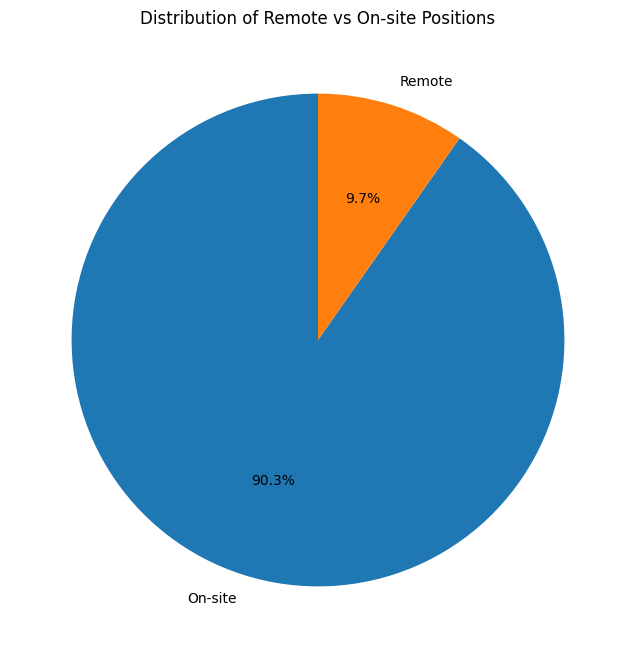

In [14]:
remote_counts = df['is_remote'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(remote_counts, labels=['On-site', 'Remote'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Remote vs On-site Positions')
plt.show()


### Top Paying Locations On Average

C:\Users\hp\AppData\Local\Temp\ipykernel_5984\2931021140.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='salary_avg', y='clean_location', data=geo_df, palette='viridis')


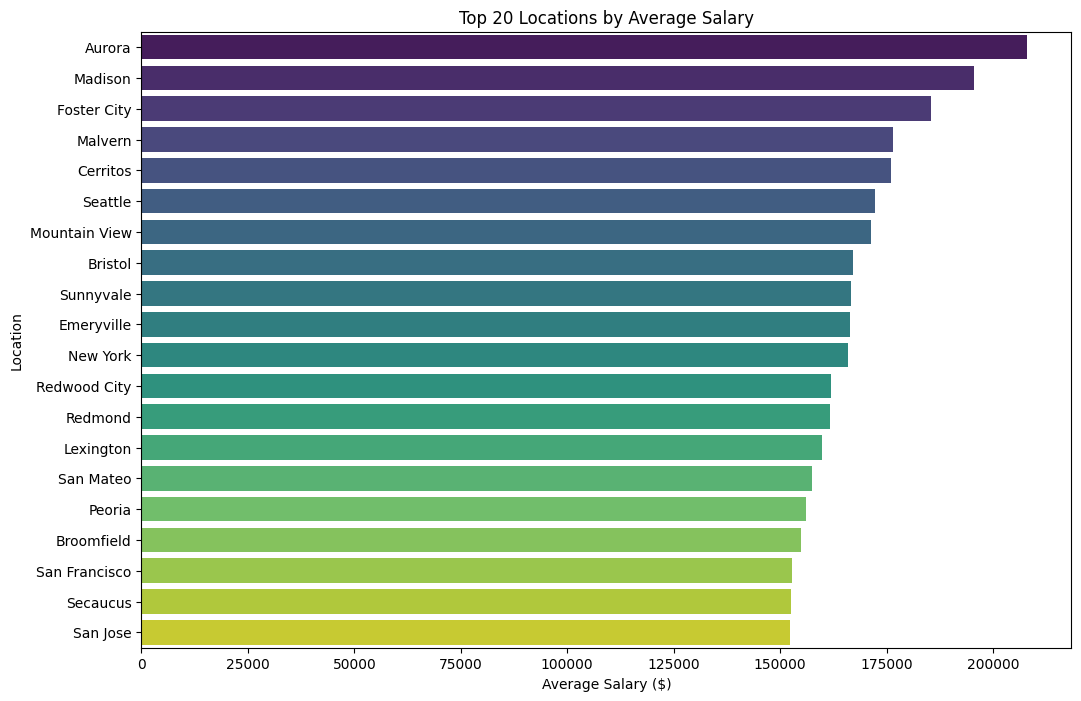

In [9]:
geo_df = df[df['clean_location'] != 'Remote'].groupby('clean_location')['salary_avg'].mean().reset_index()
geo_df = geo_df.sort_values('salary_avg', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='salary_avg', y='clean_location', data=geo_df, palette='viridis')
plt.title('Top 20 Locations by Average Salary')
plt.xlabel('Average Salary ($)')
plt.ylabel('Location')
plt.show()

### Average Salary For Each Job

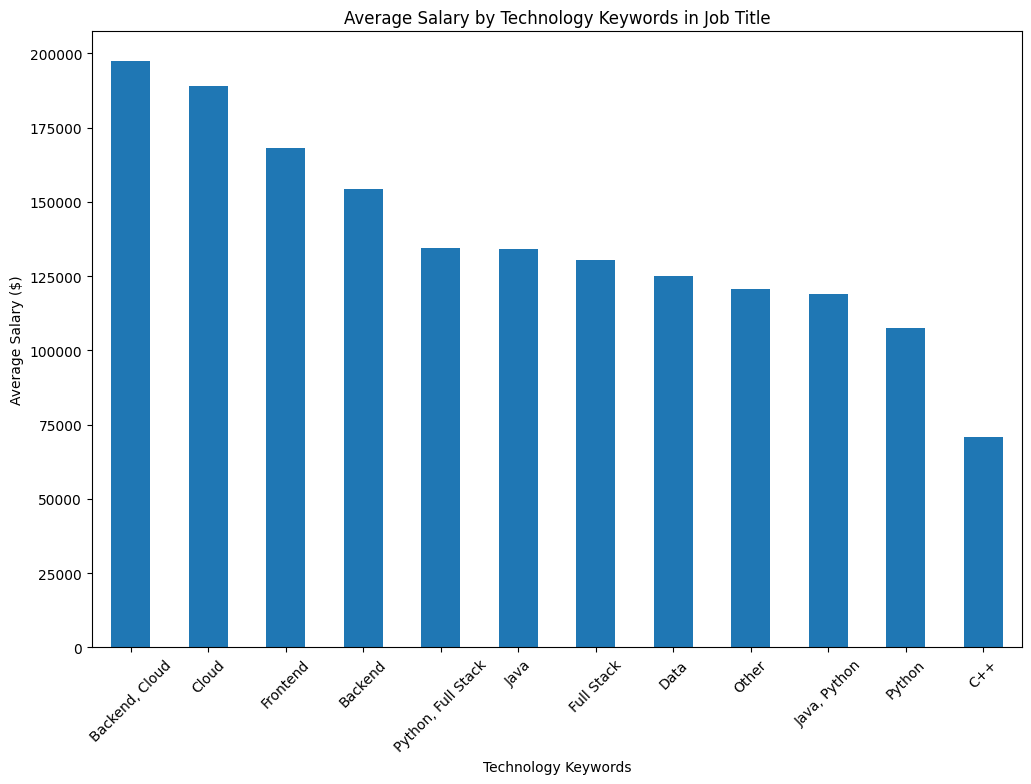

In [13]:
plt.figure(figsize=(12, 8))
tech_salaries.plot(kind='bar')
plt.title('Average Salary by Technology Keywords in Job Title')
plt.xlabel('Technology Keywords')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45)
plt.show()